In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
print(dataset.keys())
print(info)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
dict_keys(['train', 'test'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/tmp/tmp6b356p4stfds',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),

In [3]:
# preparing data
def random_flip(input_image, input_mask):
    ''' do a random flip of the image and mask'''
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    return input_image, input_mask
 
def normalize(input_image, input_mask):
    '''
    normalize the input image pixel values to be from [0,1]
    subtract 1 from the mask labels to have a range from [0,2]
    '''
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask
 
def load_image_train(datapoint):
    ''' resize, normalize and flips the training data '''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
 
    return input_image, input_mask
 
def load_image_test(datapoint):
    ''' resize and normalize the test data'''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
 
    return input_image, input_mask

# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [4]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
 
# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
 
# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
 
# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']
 
def display_with_metrics(display_list, iou_list, dice_score_list):
    ''' displays a list of images/masks and overlays a list of IoU and Dice Score '''
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list))]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True) # sort in place
 
    display_string_list = [f"{class_names[idx]}: IoU: {iou} Dice Score: {dice_score}" for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)
 
    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)
 
def display(display_list, titles=[], display_string=None):
    ''' displays list of images/masks'''
    plt.figure(figsize=(15,15))
 
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    
    plt.show()
 
def show_image_from_dataset(dataset):
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=['Image', 'True Maks'])

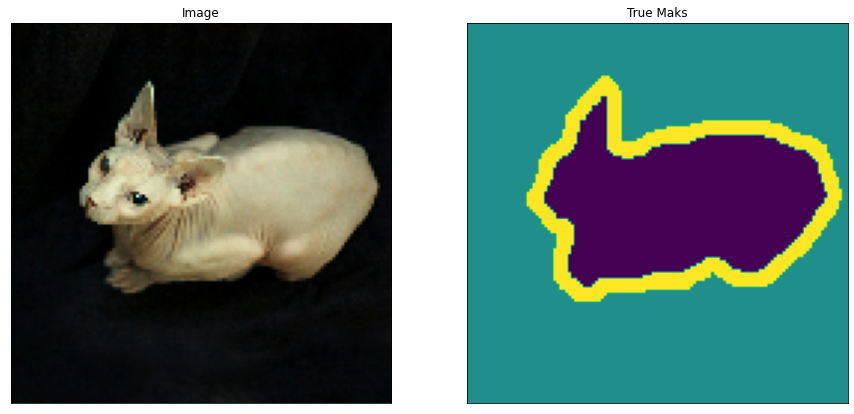

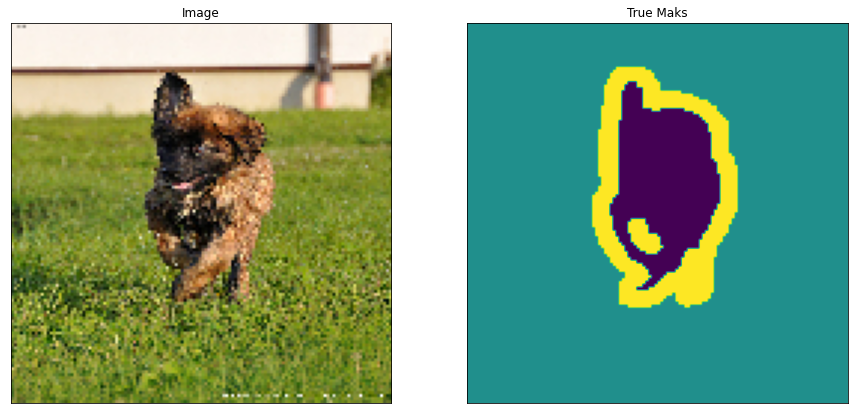

In [6]:
# display an image from the train set
show_image_from_dataset(train)
 
# display an image from the test set
show_image_from_dataset(test)

In [7]:
# Encoder
 
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    '''
    Add 2 convolutional layers with the parameters
    '''
 
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                                   kernel_initializer='he_normal', activation='relu', padding='same')(x)
    return x
 
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Add 2 convolutional blocks and then perform down sampling on output of convolutions
    '''
 
    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
 
    return f, p
 
def encoder(inputs):
    '''
    defines the encoder or downsampling path.
    '''
    
    f1, p1 = encoder_block(inputs, n_filters=64)
    f2, p2 = encoder_block(p1, n_filters=128)
    f3, p3 = encoder_block(p2, n_filters=256)
    f4, p4 = encoder_block(p3, n_filters=512)
 
    return p4, (f1, f2, f3, f4)

In [8]:
# Bottleneck
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck

In [9]:
# Decoder
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet
    '''
 
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters)
 
    return c
 
def decoder(inputs, convs, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 
    '''
 
    f1, f2, f3, f4 = convs
 
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=3, strides=2)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=3, strides=2)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=3, strides=2)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=3, strides=2)
 
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(c9)
 
    return outputs

In [10]:
# putting it all together
OUTPUT_CHANNELS = 3
 
def UNet():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder
    '''
 
    inputs = tf.keras.layers.Input(shape=(128,128,3,))
 
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, OUTPUT_CHANNELS)
 
    model = tf.keras.Model(inputs, outputs)
 
    return model
 
model = UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [12]:
# configure the training parameters and train the model
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
 
# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/20


: 

: 

In [ ]:
# Plot the training and validation loss
def plot_metrics(model_history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name], 'b', label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], 'g', label='val_'+metric_name)
    plt.legend()
    
plot_metrics(model_history, "loss", title="Training vs Validation Loss", ylim=1)

In [ ]:
# Prediction Utilities
def get_test_image_and_annotation_arrays():
    '''
    Unpacks the test dataset and returns the input images and segmentation masks
    '''
 
    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)
 
    images = []
    y_true_segments = []
 
    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()
    
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
 
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments
 
def create_mask(pred_mask):
    '''
    Creates the segmentation mask by getting the channel with the highest probability. Remember that we
    have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
    highest probability.
    '''
 
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()
 
def make_predictions(image, mask, num=1):
    '''
    Feeds an image to a model and returns the predicted mask
    '''
 
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
 
    return pred_mask
    
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []
 
    smoothening_factor = 0.00001
    
    for i in range(3):
        intersection = np.sum((y_pred==i) * (y_true==i))
        y_true_area = np.sum((y_true==i))
        y_pred_area = np.sum((y_pred==i))
        combined_area = y_true_area + y_pred_area
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
    
    return class_wise_iou, class_wise_dice_score

In [ ]:
# Setup the ground truth and predictions.
# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
 
# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]
 
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou))

In [ ]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score))


In [ ]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 2800
 
# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
 
# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  
 
# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)